# Importation:

In [1]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cleaning:

## Lecture et information sur les données:

In [2]:
df1 = pd.read_csv("C:\\Users\\utilisateur\\Documents\\Projet_ML_gr3\\data\\indeed_mongo.csv")
df = pd.read_csv("C:\\Users\\utilisateur\\Documents\\Projet_ML_gr3\\data\\indeed.pre_processing.csv")

In [3]:
df.head(6)

,_id,adresse,date_de_publication,description,localisation,nom_entreprise,salaire,titre,type_de_contrat,url,...,laravel,hololens,docker,jira,scrum,kanban,azure,aws,teamcity,jenkins
0,5da04bf5559bce5541bcce8f,5 avis,2019-10-08 19:42:40.904000,Toulouse (31)VIDAL ASSOCIATES Consulting & Sea...,Toulouse,Vidal Associates,NaN,Développeur Sénior Java/ J2E h/f,NaN,https://www.indeed.fr/rc/clk?jk=e3fc82878e0491...,...,0,0,0,0,1,0,0,0,0,1
1,5da04bf5559bce5541bcce90,2 avis,2019-10-16 19:42:42.618000,Toulouse (31)CDIChez notre client grand compte...,Toulouse,MGI Consultants,NaN,Expert performance - infrastructure,CDI,https://www.indeed.fr/rc/clk?jk=9d3a85e0205ca0...,...,0,0,0,0,0,0,0,0,0,0
2,5da04bf5559bce5541bcce91,Labège (31),2019-09-19 19:42:43.947000,Labège (31)CDIStartup de l’IoT Valley labellis...,Toulouse,cenareo,NaN,DevOps / SRE,CDI,https://www.indeed.fr/rc/clk?jk=cdc48a4dcf7c15...,...,0,0,1,1,0,0,1,0,0,0
3,5da04bf5559bce5541bcce92,Toulouse (31),2019-09-18 19:42:45.732000,Toulouse (31)CDIL’equipe SRE est responsable d...,Toulouse,Sigfox,NaN,Service Reliability Engineer (SRE) F/H,CDI,https://www.indeed.fr/rc/clk?jk=5b7f648563c94f...,...,0,0,1,0,0,0,0,1,0,0
4,5da04bf5559bce5541bcce93,Toulouse (31),2019-09-16 19:42:47.881000,Toulouse (31)30 000 € - 34 000 € par anWiSEED ...,Toulouse,Wiseed,30 000 € - 34 000 € par an,DEVELOPPEUR(SE) BACKEND JAVA/WEB (H/F),NaN,https://www.indeed.fr/rc/clk?jk=d625e0f2a0ab61...,...,0,0,0,1,0,0,0,0,0,1
5,5da04bf5559bce5541bcce94,5 avis,2019-09-16 19:42:49.227000,Toulouse (31)VIDAL ASSOCIATES Consulting & Sea...,Toulouse,Vidal Associates,NaN,Développeur Java / Jee/ Spring f/h,NaN,https://www.indeed.fr/rc/clk?jk=0eaed1137edb2e...,...,0,0,0,0,1,0,0,0,0,1


In [4]:
df['salaire'][4]

'30\xa0000 € - 34\xa0000 € par an'

In [5]:
df.shape

(8140, 210)

In [6]:
pd.isna(df).sum(axis = 0)

_id                            0
adresse                        0
date_de_publication            1
description                    0
localisation                   0
nom_entreprise                13
salaire                     6436
titre                          0
type_de_contrat             2982
url                            0
salaire_moyen                  0
niveau_etude                3841
Lyon                           0
type_contrat_description    2142
Nantes                         0
Paris                          0
Toulouse                       0
bac + 1                        0
bac + 2                        0
bac + 3                        0
bac + 4                        0
bac + 5                        0
diplôme supérieur              0
ingénieur                      0
master 1                       0
master 2                       0
Apprentissage                  0
Autre                          0
CDD                            0
CDI                            0
          

## Fonction qui calcule le salaire moyen:

In [7]:
def salary_man(df):
    salaire_moyen = []
    for i in range(len(df)):
        try:
            salaire_liste = re.findall('(\d+),?',normalize('NFKD',df['salaire'][i]).replace(' ',''))
            mois = re.search('mois',df['salaire'][i])
            jour = re.search('jour',df['salaire'][i])
            heure = re.search('heure',df['salaire'][i])
            if mois:
                if len(salaire_liste) > 1:
                    moy = 12 * (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    salaire_moyen.append(moy)
                else:
                    salaire_moyen.append(int(salaire_liste[0]) * 12)
            elif jour:
                # Le nombre de jours travaillés maximum retenu sur la période de référence est de 261 jours.
                if len(salaire_liste) > 1:
                    moy = 261 * (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    salaire_moyen.append(moy)
                else:
                    salaire_moyen.append(int(salaire_liste[0]) * 261)
            elif heure:
                # 1600 heures travaillées par an.
                if len(salaire_liste) > 1:
                    moy = (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    if moy < 20:
                    #grande chance que le salaire soit exprimé en fait en k euros:
                        salaire_moyen.append(moy * 1600)
                    else:
                        salaire_moyen.append(moy * 1000)
                else:
                    if int(salaire_liste[0]) < 20:
                        salaire_moyen.append(int(salaire_liste[0]) * 1600)
                    else:
                        salaire_moyen.append(int(salaire_liste[0]) * 1000)
            else:
                if len(salaire_liste) > 1:
                    moy = (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    salaire_moyen.append(moy)
                else:
                    salaire_moyen.append(int(salaire_liste[0]))
                    
        except:
            salaire_moyen.append('None')
            continue
    return salaire_moyen

salaire_moyen = salary_man(df)

#df.insert(6, "salaire_moyen", salaire_moyen, True)
df['salaire_moyen'] = salaire_moyen

In [8]:
df.head()

,_id,adresse,date_de_publication,description,localisation,nom_entreprise,salaire,titre,type_de_contrat,url,...,laravel,hololens,docker,jira,scrum,kanban,azure,aws,teamcity,jenkins
0,5da04bf5559bce5541bcce8f,5 avis,2019-10-08 19:42:40.904000,Toulouse (31)VIDAL ASSOCIATES Consulting & Sea...,Toulouse,Vidal Associates,NaN,Développeur Sénior Java/ J2E h/f,NaN,https://www.indeed.fr/rc/clk?jk=e3fc82878e0491...,...,0,0,0,0,1,0,0,0,0,1
1,5da04bf5559bce5541bcce90,2 avis,2019-10-16 19:42:42.618000,Toulouse (31)CDIChez notre client grand compte...,Toulouse,MGI Consultants,NaN,Expert performance - infrastructure,CDI,https://www.indeed.fr/rc/clk?jk=9d3a85e0205ca0...,...,0,0,0,0,0,0,0,0,0,0
2,5da04bf5559bce5541bcce91,Labège (31),2019-09-19 19:42:43.947000,Labège (31)CDIStartup de l’IoT Valley labellis...,Toulouse,cenareo,NaN,DevOps / SRE,CDI,https://www.indeed.fr/rc/clk?jk=cdc48a4dcf7c15...,...,0,0,1,1,0,0,1,0,0,0
3,5da04bf5559bce5541bcce92,Toulouse (31),2019-09-18 19:42:45.732000,Toulouse (31)CDIL’equipe SRE est responsable d...,Toulouse,Sigfox,NaN,Service Reliability Engineer (SRE) F/H,CDI,https://www.indeed.fr/rc/clk?jk=5b7f648563c94f...,...,0,0,1,0,0,0,0,1,0,0
4,5da04bf5559bce5541bcce93,Toulouse (31),2019-09-16 19:42:47.881000,Toulouse (31)30 000 € - 34 000 € par anWiSEED ...,Toulouse,Wiseed,30 000 € - 34 000 € par an,DEVELOPPEUR(SE) BACKEND JAVA/WEB (H/F),NaN,https://www.indeed.fr/rc/clk?jk=d625e0f2a0ab61...,...,0,0,0,1,0,0,0,0,0,1


In [9]:
regex = df[['description','type_de_contrat']]

In [10]:
regex.head()

,description,type_de_contrat
0,Toulouse (31)VIDAL ASSOCIATES Consulting & Sea...,NaN
1,Toulouse (31)CDIChez notre client grand compte...,CDI
2,Labège (31)CDIStartup de l’IoT Valley labellis...,CDI
3,Toulouse (31)CDIL’equipe SRE est responsable d...,CDI
4,Toulouse (31)30 000 € - 34 000 € par anWiSEED ...,NaN


In [11]:
print(df['description'][2])

Labège (31)CDIStartup de l’IoT Valley labellisée Pass French French Tech’, créée en 2012 par 4 ingénieurs, Cenareo développe un CMS (Content Management System) dédié à l'affichage dynamique. Intuitive et collaborative, la plateforme SaaS permet de créer, gérer et diffuser des contenus sur des écrans d'affichage en temps réel, à partir de n’importe quel PC, tablette ou smartphone.
En hyper croissance depuis sa création, Cenareo vient d’ouvrir son premier bureau hors de France, à Munich.
Avec des ambitions internationales affirmées, elle accueille les candidats multiculturels et étrangers. L’anglais devient la première langue parlée dans l’entreprise.

Cenareo emploie plus de 35 personnes en phase avec cette orientation qui renforce les valeurs de l’entreprise :
Satisfaction Client
Excellence Produit
Audace & Ambition
Inventivité
Esprits d’équipe

L'équipe :
Vous rejoindrez une équipe de passionnés par les nouvelles technologies, la vidéo et le billard ! Créative et portée par les challe

In [12]:
contrat = ['cdi', 'cdd', 'stage', 'alternance', 'freelance']
data = []
for i in range(len(df)):
    inside_data = []
    for ele in contrat:
        pattern = re.compile(r"[\s/\(\),.]"+ele+r"[\s/\(\),.]")
        value = pattern.search(df['description'][i].lower().replace('\n',' ').replace('\r',' '))
        if value:
            inside_data.append(1)
        else:
            inside_data.append(0)
    data.append(inside_data)

desc = titre = [ele+'_desc' for ele in contrat]
contrat_desc = pd.DataFrame(data, columns=desc)
contrat_desc.sum()

cdi_desc           1836
cdd_desc            148
stage_desc          786
alternance_desc     225
freelance_desc      409
dtype: int64

In [13]:
contrat_desc[contrat_desc['freelance_desc'] == 1]

,cdi_desc,cdd_desc,stage_desc,alternance_desc,freelance_desc
49,1,0,0,0,1
69,0,0,0,0,1
88,0,0,0,0,1
116,0,0,0,0,1
122,0,0,0,0,1
125,0,0,0,0,1
128,0,0,0,0,1
130,0,0,0,0,1
133,0,0,0,0,1
140,0,0,0,0,1


In [14]:
contrat = ['cdi', 'cdd', 'stage', 'alternance', 'freelance']
data = []
for i in range(len(df)):
    inside_data = []
    for ele in contrat:
        pattern = re.compile(r"[\s/\(\),.]"+ele+r"[\s/\(\),.]?")
        value = pattern.search(df['titre'][i].lower().replace('\n',' ').replace('\r',' '))
        if value:
            inside_data.append(1)
        else:
            inside_data.append(0)
    data.append(inside_data)
titre = [ele+'_titre' for ele in contrat]
contrat_titre = pd.DataFrame(data, columns=titre)
contrat_titre.sum()

cdi_titre           122
cdd_titre            18
stage_titre          86
alternance_titre     55
freelance_titre     282
dtype: int64

In [15]:
contrat_titre[contrat_titre['freelance_titre'] == 1]

,cdi_titre,cdd_titre,stage_titre,alternance_titre,freelance_titre
69,0,0,0,0,1
88,0,0,0,0,1
122,0,0,0,0,1
125,0,0,0,0,1
128,0,0,0,0,1
140,0,0,0,0,1
158,0,0,0,0,1
206,0,0,0,0,1
262,0,0,0,0,1
323,0,0,0,0,1


In [19]:
liste_langage = ['python', 'r','vba', 'mysql','excel','asp.net','nosql','sql','linux','mongodb',
            'mariadb','java','javascript','php','html','css','sas','c#','ruby','swift','objective-c',
            'vb.net','kotlin','scala','bash','powershell','shell','front end','back end','soap',
            'dasl', 'pict', 'rexx', 'd', 'asp.net', 'f#', 'joy', 'sr', 'back end', 'poplog', 
            'modula-2', 'powershell', 'bash', 'concurrent pascal', 'apl', 'eiffel', 'lisp', 
            'cilk', 'c', 'awk', 'charity', 'bliss', 'spin', 'swift', 'visual basic', 'game maker language',
            'lisaac', 'xl', 'nosql', 'limbo', 'e', 'lava', 'slate', 'revolution', 'coldfusion', 
            'matlab', 'vb.net', 'cobol', 'tcl', 'rpg', 'sas', 'curl', 'front end', 'nemerle', 'f-script', 
            'xml', 's-lang', 'curry', 'basic', 'autoit', 'prolog', 'erlang', 'maya embedded language', 
            'frink', 'oz', 'windows powershell', 'beta', 'moo', 'object-z', 'self', 'leda', 'fortran', 
            'smalltalk', 'afnix', 'mysql', 'm', 'turing', 'jovial', 'lua', 'mondrian', 'io', 'salsa', 
            'kotlin', 'css', 'xotcl', 'perl', 'component pascal', 'mongodb', 'xhtml', 'dibol', 'oberon',
            'ada', 'visual foxpro', 'clist', 'pl/c', 'algol', 'mariadb', 'sql', 'pliant', 'excel', 
            'cobra', 'occam', 'obliq', 'prograph', 'chuck', 'pl/i', 'hypertalk', 'forth', 'ici', 
            'vba', 'beanshell', 'sgml', 'soap', 'opal', 'small', 'pascal', 'applescript', 'roop', 
            'agora', 'moto', 'rapira', 'alf', 'r', 'ml', 'javascript', 'pcastl', 'abcl', 'postscript', 
            'oxygene', 'cecil', 'clean', 'ops5', 'c\\+\\+', 'shell', 'haskell', 'kite', 'cleo', 'q', 'linux', 
                'vbscript', 'joule', 'rebol', 'jass', 'j', 'fril']

liste_outils = ['tableau', 'powerbi','symfony', 'jquery','angular','react','react native','node js','git','github',
            'visual studio','django','flask','api rest','laravel', 'hololens', 'docker', 'jira', 'scrum', 'kanban', 
               'azure','aws', 'teamcity', 'jenkins']

lieu = pd.get_dummies(df['localisation']).drop(['Bordeaux'], axis = 1)
langage = df[liste_langage]
outils = df[liste_outils]


In [20]:
X_Y = pd.concat([lieu, langage, outils, contrat_titre, contrat_desc,df['salaire_moyen']],axis = 1)
X_Y.shape

(8140, 204)

In [21]:
(X_Y['salaire_moyen'] != 'None').sum()

1704

In [22]:
Y = X_Y['salaire_moyen'][X_Y['salaire_moyen'] != 'None']
X = X_Y[X_Y['salaire_moyen'] != 'None'].drop(['salaire_moyen'], axis = 1)

In [23]:
X.head()

,Lyon,Nantes,Paris,Toulouse,python,r,vba,mysql,excel,asp.net,...,cdi_titre,cdd_titre,stage_titre,alternance_titre,freelance_titre,cdi_desc,cdd_desc,stage_desc,alternance_desc,freelance_desc
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
20,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


# Grid search:

In [24]:
X_train, X_test, y_trainy, y_testy = train_test_split(X,Y , test_size=0.25, random_state=0)

In [25]:
y_trainy

354      40000
2823     40000
1036     30000
7741     42000
7207     32500
2611     50000
1681     36000
266      37500
4071     48000
4272     50000
7046     45000
7380     47500
1363     55000
6586     42000
7276     52500
1087     52500
1469      8400
4795     42500
1054     35000
2068     55000
3870     32000
5318     65000
5643     55000
5091     47500
5644     60000
1751    130500
1422      7800
1728     52500
4974     45000
3980     45000
         ...  
7003     34200
3850     48000
4746     40000
570      35000
3924     32500
343      37500
4135     52500
2605     32500
4143     46000
7706     47500
836      39500
429      52500
2691     41500
7194     15060
3686     52500
1522     69000
6863     40000
3104     40000
7134     40000
5127     34000
3099     45000
1360     32000
4940     65000
6729     52500
3876     42000
4104     47500
5852     57500
7858     52500
2759     41500
3603     30500
Name: salaire_moyen, Length: 1278, dtype: object

## Création des classes avec K-means:

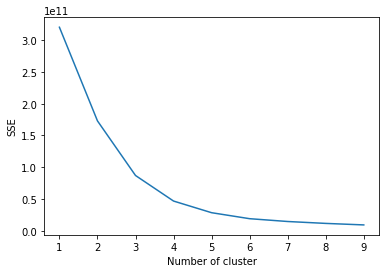

In [26]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter=1000).fit(y_trainy.values.reshape(-1, 1))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4,init = 'k-means++', max_iter=1000).fit(y_trainy.values.reshape(-1, 1))
y_train = kmeans.labels_
y_test = kmeans.predict(y_testy.values.reshape(-1, 1))

(array([440.,   0.,   0., 714.,   0.,   0.,  35.,   0.,   0.,  89.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

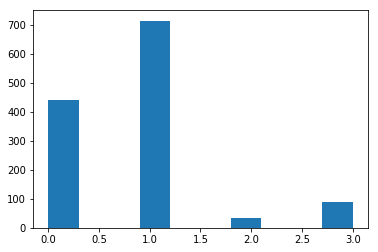

In [28]:
plt.hist(y_train)

In [29]:
centroid = kmeans.cluster_centers_
centroid.sort(axis = 0)
centre = list(centroid.reshape(1,-1)[0])
classe = [(centre[i]+centre[i+1])/2 for i in range(len(centre) - 1)]
print(centre)
print(classe)

[15949.780898876397, 39361.34453781517, 55011.09090909094, 106383.57142857139]
[27655.562718345784, 47186.21772345305, 80697.33116883117]


In [30]:
Y[Y > 79330]

206     104400
345     104400
440     143550
694     130500
756     104400
780      91350
838     120000
1373    104400
1690    117450
1732    104400
1751    130500
1753    104400
2700     86130
3237     82500
3243    130500
3499    110925
4100     82500
4240    104400
4444    104400
4481    104400
4539    104400
4627    110925
4760     90000
5066    104400
5112    104400
5394    104400
5419    120000
5613    110925
5641    117450
5982    117450
6185    104400
6191    130500
6538     80000
7091     83520
7160    104400
7264    104400
7402    104400
7404    104400
7713     95000
7805    104400
7857    104400
7897    104400
8043    104400
8058    104400
Name: salaire_moyen, dtype: object

In [31]:
s4l4ce = df[df['salaire_moyen'] != 'None']
s4l4ce[s4l4ce['salaire_moyen'] > 79000]

,_id,adresse,date_de_publication,description,localisation,nom_entreprise,salaire,titre,type_de_contrat,url,...,laravel,hololens,docker,jira,scrum,kanban,azure,aws,teamcity,jenkins
206,5da04bf6559bce5541bccf5d,France,2019-09-26 19:49:03.004000,FranceFreelance / Indépendant300 € - 500 € par...,Toulouse,IFEO,300 € - 500 € par jour,Développeur Font End - Freelance H/F,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,...,0,0,0,0,0,0,0,0,0,0
345,5da05a01559bce5541bcd46f,44000 Nantes,2019-09-23 19:53:33.526000,44000 NantesFreelance / Indépendant300 € - 500...,Nantes,TEAM CONSULTING SARL,300 € - 500 € par jour,Développeur Mobile IOS & ANDROID - REF K - Fre...,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,...,0,0,0,0,0,0,0,0,0,0
440,5da05a01559bce5541bcd4ce,Paris (75),2019-09-16 19:56:30.912000,"Paris (75)Freelance / Indépendant, CDI550 € pa...",Paris,Warren Walter,550 € par jour,Développeur double compétence Android/iOS natif,"Freelance / Indépendant, CDI",https://www.indeed.fr/company/Warren-walter/jo...,...,0,0,0,0,0,0,0,0,0,0
694,5da05a01559bce5541bcd5ce,Paris (75),2019-10-09 20:04:59.895000,"Paris (75)Temps plein, Freelance / Indépendant...",Paris,SKILLWISE,500 € par jour,Développeur iOS - H/F / Freelance,"Temps plein, Freelance / Indépendant",https://www.indeed.fr/rc/clk?jk=2984f4b5b953e5...,...,0,0,0,0,1,1,0,0,0,0
756,5da05a01559bce5541bcd60c,69000 Lyon,2019-09-16 20:06:52.626000,69000 LyonFreelance / Indépendant300 € - 500 €...,Lyon,TEAM CONSULTING SARL,300 € - 500 € par jour,Developpeur JAVA - REF AP - Freelance H/F,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,...,0,0,0,0,0,0,0,0,0,0
780,5da05a01559bce5541bcd624,Pessac (33),2019-09-16 20:07:35.586000,"Pessac (33)Temps plein, Freelance / Indépendan...",Bordeaux,EMGS CONSULTING,350 € par jour,Uregent Développeur IOS Objective-C Swift / Fr...,"Temps plein, Freelance / Indépendant",https://www.indeed.fr/rc/clk?jk=9419b1fc3a8a05...,...,0,0,0,0,1,0,1,0,0,0
838,5da05a01559bce5541bcd65e,2 avis,2019-09-16 20:10:26.952000,Paris (75)CDI120 000 € par an.net core / Azure...,Paris,Blue search conseil,120 000 € par an,CTO/Chief technical officer Digital - H/F,CDI,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,...,0,0,0,0,1,0,0,0,0,0
1373,5da05a02559bce5541bcd876,Paris (75),2019-09-23 20:35:29.468000,Paris (75)Freelance / Indépendant300 € - 500 €...,Paris,TEAM CONSULTING SARL,300 € - 500 € par jour,Développeur JAVA 8/ SPRING BOOT - REF K - Free...,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,...,0,0,0,0,0,0,0,0,0,0
1690,5da05a03559bce5541bcd9b3,Arcueil (94),2019-09-19 20:49:58.140000,"Arcueil (94)Temps plein, Freelance / Indépenda...",Paris,WorldWide People,450 € par jour,Développeur CHATBOT. / Freelance,"Temps plein, Freelance / Indépendant",https://www.indeed.fr/rc/clk?jk=f2e6ec01a5ca04...,...,0,0,0,0,0,0,0,0,0,0
1732,5da05a03559bce5541bcd9dd,6 avis,2019-09-27 20:51:27.255000,Nantes (44)400 € par jourIntégré(e) au sein de...,Nantes,EXPERTIME,400 € par jour,Développeur(se) .NET,NaN,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,...,0,0,0,0,1,0,1,0,0,0


In [32]:
df['salaire_moyen']

0        None
1        None
2        None
3        None
4       32000
5        None
6        None
7        None
8        6600
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19      42500
20      40000
21       None
22       None
23      43500
24      37000
25      50000
26      37000
27       None
28       None
29       None
        ...  
8110     None
8111     None
8112     None
8113     None
8114     None
8115     None
8116     None
8117     None
8118     None
8119    57500
8120    42500
8121     None
8122     None
8123     None
8124    55000
8125     None
8126     None
8127    47500
8128     None
8129     None
8130     None
8131     None
8132     None
8133     None
8134     None
8135     None
8136     None
8137     None
8138     None
8139     None
Name: salaire_moyen, Length: 8140, dtype: object

## Régression logistique:

In [33]:
svc = LogisticRegression()
parameters = [{'penalty': ['l2'],'C':[0.1,0.6,1,5,10,25],
              'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
              'solver':['lbfgs','newton-cg'],'max_iter':[1000]},
              {'penalty': ['l1','l2'],'C':[0.1,0.6,1,5,10,25],
              'multi_class':['ovr'],'class_weight':['balanced', None],
              'solver':['liblinear'],'max_iter':[1000]},{'penalty': ['l1','l2'],'C':[0.1,0.6,1,5,10,25],
              'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
              'solver':['saga'],'max_iter':[1000]}]
clf = GridSearchCV(svc, param_grid = parameters, return_train_score=True)
clf.fit(X_train, y_train)
result = pd.DataFrame.from_dict(clf.cv_results_)
#Predict values based on new parameters
y_pred = clf.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached w

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [34]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_multi_class,param_penalty,param_solver,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.033330,0.008336,0.001334,4.723259e-04,0.1,balanced,1000,ovr,l2,lbfgs,...,0.688525,0.709906,0.687793,0.018286,57,0.723854,0.713278,0.715457,0.717530,0.004560
1,0.094667,0.012289,0.001336,4.681981e-04,0.1,balanced,1000,ovr,l2,newton-cg,...,0.688525,0.709906,0.687793,0.018286,57,0.723854,0.713278,0.715457,0.717530,0.004560
2,0.023339,0.000935,0.000999,3.371748e-07,0.1,balanced,1000,multinomial,l2,lbfgs,...,0.660422,0.691038,0.661972,0.023028,87,0.709753,0.681551,0.692037,0.694447,0.011639
3,0.034002,0.001632,0.001334,4.735693e-04,0.1,balanced,1000,multinomial,l2,newton-cg,...,0.660422,0.691038,0.661972,0.023028,87,0.709753,0.681551,0.692037,0.694447,0.011639
4,0.022999,0.002160,0.001667,4.721021e-04,0.1,None,1000,ovr,l2,lbfgs,...,0.653396,0.702830,0.676056,0.020360,76,0.715629,0.710928,0.709602,0.712053,0.002586
5,0.081336,0.001241,0.001666,4.692382e-04,0.1,None,1000,ovr,l2,newton-cg,...,0.653396,0.702830,0.676056,0.020360,76,0.715629,0.710928,0.709602,0.712053,0.002586
6,0.026998,0.004316,0.001333,4.727753e-04,0.1,None,1000,multinomial,l2,lbfgs,...,0.658080,0.700472,0.676056,0.017857,76,0.728555,0.710928,0.727166,0.722216,0.008002
7,0.038666,0.001249,0.000999,9.199649e-07,0.1,None,1000,multinomial,l2,newton-cg,...,0.658080,0.700472,0.676056,0.017857,76,0.728555,0.710928,0.727166,0.722216,0.008002
8,0.045667,0.005437,0.001336,4.728881e-04,0.6,balanced,1000,ovr,l2,lbfgs,...,0.683841,0.700472,0.688576,0.008436,53,0.737955,0.725029,0.731850,0.731612,0.005280
9,0.110667,0.004784,0.001667,4.723819e-04,0.6,balanced,1000,ovr,l2,newton-cg,...,0.683841,0.700472,0.688576,0.008436,53,0.737955,0.725029,0.731850,0.731612,0.005280


In [35]:
print(metrics.accuracy_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

0.6619718309859155


array([[ 71,  53,   0,   2],
       [ 62, 192,   1,   3],
       [  2,   0,   6,   0],
       [  6,  15,   0,  13]], dtype=int64)

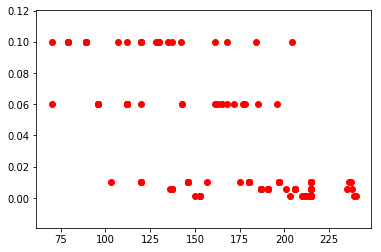

In [68]:
plt.scatter(result['rank_test_score'][result['param_C'] < 0.2],result['param_C'][result['param_C'] < 0.2],color='red')

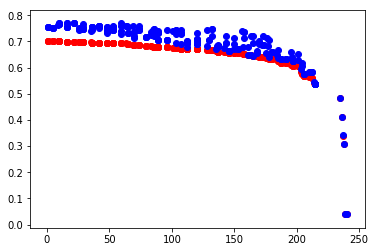

In [111]:
plt.scatter(result['rank_test_score'],result['mean_test_score'],color='red')
plt.scatter(result['rank_test_score'],result['mean_train_score'],color='blue')

In [69]:
model = SVC()
hyperparameters = [
  {'C': [0.1,0.6,1,5,10,25],'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['linear'], 'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25], 'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['rbf'], 'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25], 'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['poly'], 'degree': [2,3,4,5,6,7],
     'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25],'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['sigmoid'], 'decision_function_shape': ['ovo', 'ovr']}
 ]
clf_SVM = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True)
clf_SVM.fit(X_train, y_train)
result_SVM = pd.DataFrame.from_dict(clf_SVM.cv_results_)
#Predict values based on new parameters
y_pred_SVM = clf_SVM.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [70]:
print(metrics.accuracy_score(y_test, y_pred_SVM))
metrics.confusion_matrix(y_test, y_pred_SVM)

0.7653508771929824


array([[213,  49,   0,   4],
       [ 37, 108,   1,   1],
       [  2,   1,  12,   0],
       [  6,   6,   0,  16]], dtype=int64)

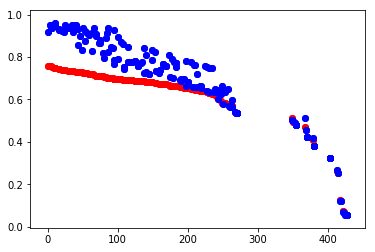

In [71]:
plt.scatter(result_SVM['rank_test_score'],result_SVM['mean_test_score'],color='red')
plt.scatter(result_SVM['rank_test_score'],result_SVM['mean_train_score'],color='blue')

In [74]:
model = RandomForestClassifier()
hyperparameters = {'n_estimators': [10,50,100,150,200],
                   "criterion": ["gini", "entropy"],
                   "max_depth": [3, 5, None],
                   "min_samples_split": [2, 3, 5, 10],
                   "max_features": ["auto", "sqrt", "log2", None],
                   "bootstrap": [True, False],
                   "class_weight": ["balanced", "balanced_subsample", None]
                  }
clf_RFC = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True)
clf_RFC.fit(X_train, y_train)
result_RFC = pd.DataFrame.from_dict(clf_RFC.cv_results_)
#Predict values based on new parameters
y_pred_RFC = clf_RFC.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [75]:
print(metrics.accuracy_score(y_test, y_pred_RFC))
metrics.confusion_matrix(y_test, y_pred_RFC)

0.8048245614035088


array([[230,  35,   0,   1],
       [ 37, 109,   1,   0],
       [  2,   1,  12,   0],
       [  6,   6,   0,  16]], dtype=int64)

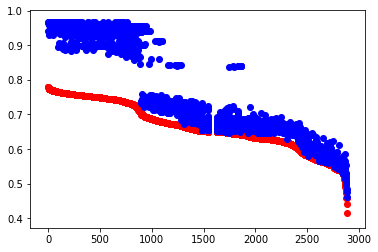

In [76]:
plt.scatter(result_RFC['rank_test_score'],result_RFC['mean_test_score'],color='red')
plt.scatter(result_RFC['rank_test_score'],result_RFC['mean_train_score'],color='blue')

In [77]:
result_RFC

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_split,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.028667,1.700565e-03,0.005009,1.315558e-05,True,balanced,gini,3,auto,2,...,0.512088,0.427313,0.520498,0.079490,2854,0.679868,0.514819,0.510965,0.568551,0.078729
1,0.104048,4.257291e-03,0.014664,4.717101e-04,True,balanced,gini,3,auto,2,...,0.646154,0.656388,0.649341,0.004979,1626,0.688669,0.668496,0.698465,0.685210,0.012477
2,0.201343,3.092894e-03,0.026997,4.331810e-03,True,balanced,gini,3,auto,2,...,0.679121,0.627753,0.656662,0.021431,1408,0.704070,0.684962,0.678728,0.689253,0.010782
3,0.287670,1.461355e-02,0.033346,1.875709e-03,True,balanced,gini,3,auto,2,...,0.661538,0.643172,0.647877,0.009808,1705,0.688669,0.675082,0.701754,0.688502,0.010889
4,0.395322,9.110385e-03,0.045337,2.035189e-03,True,balanced,gini,3,auto,2,...,0.681319,0.654185,0.664714,0.011875,1313,0.691969,0.701427,0.710526,0.701308,0.007576
5,0.026013,8.244310e-04,0.004999,7.370010e-07,True,balanced,gini,3,auto,3,...,0.626374,0.594714,0.543924,0.094864,2775,0.475248,0.603732,0.630482,0.569821,0.067759
6,0.112331,1.188556e-02,0.013994,1.417266e-03,True,balanced,gini,3,auto,3,...,0.668132,0.632159,0.641288,0.019288,1876,0.654565,0.663008,0.683114,0.666896,0.011975
7,0.188002,8.485678e-03,0.023666,4.722133e-04,True,balanced,gini,3,auto,3,...,0.670330,0.676211,0.670571,0.004496,1233,0.693069,0.711306,0.712719,0.705698,0.008949
8,0.302333,2.206932e-02,0.035671,1.251296e-03,True,balanced,gini,3,auto,3,...,0.654945,0.647577,0.652269,0.003322,1466,0.698570,0.684962,0.686404,0.689978,0.006104
9,0.401670,3.364479e-02,0.043663,9.459779e-04,True,balanced,gini,3,auto,3,...,0.672527,0.656388,0.659590,0.009520,1367,0.697470,0.690450,0.712719,0.700213,0.009296


In [ ]:
model = AdaBoostClassifier()
hyperparameters = {'n_estimators': [10,50,100,150,200],
                   'learning_rate' : [0.01,0.05,0.1,0.3,1],
                   'algorithm' : ['SAMME', 'SAMME.R']
                  }
clf_Ada = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True)
clf_Ada.fit(X_train, y_train)
result_Ada = pd.DataFrame.from_dict(clf_Ada.cv_results_)
#Predict values based on new parameters
y_pred_Ada = clf_Ada.predict(X_test)

In [72]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators